<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/movie_cluster_membership.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv
import openpyxl as op

In [4]:
data_training = pd.read_excel('data_training.xlsx',index_col=0)
data_test = pd.read_excel('data_test.xlsx',index_col=0)

X = data_training.values[:, 1:]
TEST = data_test.values

print(X.shape)
print(TEST.shape)

(943, 1682)
(10000, 3)


In [6]:
# 未評価値を各ユーザーの平均評価値で補完
ave = np.empty((X.shape[0]))
for n in range(X.shape[0]):
    n_sum = 0
    for m in range(X.shape[1]):
        n_sum += X[n][m]
    if n_sum == 0:
        ave[n] = 0
    else:
        ave[n] = n_sum/np.count_nonzero(X,axis=1)[n]

X_movie = np.asarray(X, dtype = "float")

for n in range(X.shape[0]):
  for m in range(X.shape[1]):
    if X[n][m] == 0 :
      X_movie[n][m] = ave[n]

print(X_movie)

[[5.         3.         4.         ... 3.61065574 3.61065574 3.61065574]
 [4.         3.75438596 3.75438596 ... 3.75438596 3.75438596 3.75438596]
 [2.80392157 2.80392157 2.80392157 ... 2.80392157 2.80392157 2.80392157]
 ...
 [5.         4.04761905 4.04761905 ... 4.04761905 4.04761905 4.04761905]
 [4.27027027 4.27027027 4.27027027 ... 4.27027027 4.27027027 4.27027027]
 [3.42361111 5.         3.42361111 ... 3.42361111 3.42361111 3.42361111]]


In [11]:
import numpy as np
import sys
import random

#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u, w

In [32]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  delta_max = 0
  every_cluster_objs_max = 0
  n_overlaps_max = 0
  w_max = 0
  output = []

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, rough_u, w = RSCCMM(X, C, delta) # RSCCM法を適用
    every_cluster_objs = np.sum(rough_u, axis=1) # 各クラスターの要素数
    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64)) # オーバーラップした要素数

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算
    output.append([auc, ', '.join(map(str, every_cluster_objs)), n_overlaps, X.shape[0] - n_overlaps])

    if auc > auc_max:
      auc_max = auc
      w_max = w
      delta_max = delta
      every_cluster_objs_max = every_cluster_objs
      n_overlaps_max = n_overlaps


  return auc_max, every_cluster_objs_max, n_overlaps_max, w_max, output

print(RSCCMM_CF_AUC_CLUSTER(10, TEST, X_movie, 5, -7.43))

(0.7093485047587511, array([743., 628., 856., 628., 622.]), 702.0, array([[0.00062804, 0.00059388, 0.0005892 , ..., 0.00059453, 0.00059453,
        0.00059453],
       [0.00060204, 0.00059214, 0.00059348, ..., 0.00059453, 0.00059453,
        0.00059453],
       [0.00062392, 0.0005829 , 0.00058312, ..., 0.00059453, 0.00059454,
        0.00059433],
       [0.00060426, 0.00059297, 0.00059426, ..., 0.00059313, 0.00059453,
        0.00059453],
       [0.00060402, 0.00059186, 0.00059212, ..., 0.00059453, 0.00059453,
        0.00059453]]), [[0.7034421969152906, '620.0, 876.0, 640.0, 652.0, 677.0', 687.0, 256.0], [0.7052417341453504, '632.0, 885.0, 613.0, 669.0, 636.0', 680.0, 263.0], [0.7070181446137651, '710.0, 636.0, 650.0, 853.0, 652.0', 700.0, 243.0], [0.7089015492340429, '727.0, 649.0, 631.0, 629.0, 853.0', 701.0, 242.0], [0.708892282342675, '730.0, 846.0, 616.0, 693.0, 632.0', 710.0, 233.0], [0.7093485047587511, '743.0, 628.0, 856.0, 628.0, 622.0', 702.0, 241.0], [0.7067208554546643, '7

[['AUC', '各クラスターの要素数', 'オーバーラップしている要素の数', 'オーバーラップしていない要素の数'], [0.7079738079611175, '853.0, 612.0, 753.0, 620.0, 640.0', 706.0, 237.0]]


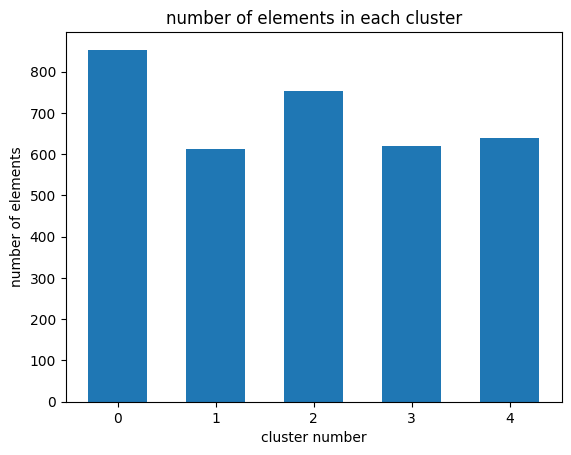

In [37]:
# 可視化
name = "ave_movie_RSCCMM_cluster"
C = 5
auc_max, every_cluster_objs_max, n_overlaps_max, w_max, output = RSCCMM_CF_AUC_CLUSTER(1, TEST, X_movie, C, -7.43)

plt.bar(range(C), every_cluster_objs_max, width=0.6)

# plt.legend()
plt.title('number of elements in each cluster')
plt.xlabel('cluster number')
plt.ylabel('number of elements')
plt.savefig(f"{name}.png", format="png", dpi=300)

csv_output = [["AUC", "各クラスターの要素数", "オーバーラップしている要素の数", "オーバーラップしていない要素の数"]]
for row in output:
  csv_output.append(row)
print(csv_output)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(csv_output)